In [1]:
%load_ext watermark
%watermark -v -n -m -p numpy,sklearn,pandas,neptune,torch

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

numpy  : 1.23.2
sklearn: 1.1.2
pandas : 1.4.3
neptune: 0.16.5
torch  : 1.12.1

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 5.15.0-46-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from datetime import datetime

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
print(PROJ_ROOT)

/home/fedesss/Dropbox/ML_to_ETa/eta_ml


array([<AxesSubplot:xlabel='Data'>, <AxesSubplot:xlabel='Data'>,
       <AxesSubplot:xlabel='Data'>, <AxesSubplot:xlabel='Data'>,
       <AxesSubplot:xlabel='Data'>, <AxesSubplot:xlabel='Data'>,
       <AxesSubplot:xlabel='Data'>, <AxesSubplot:xlabel='Data'>,
       <AxesSubplot:xlabel='Data'>, <AxesSubplot:xlabel='Data'>,
       <AxesSubplot:xlabel='Data'>, <AxesSubplot:xlabel='Data'>,
       <AxesSubplot:xlabel='Data'>], dtype=object)

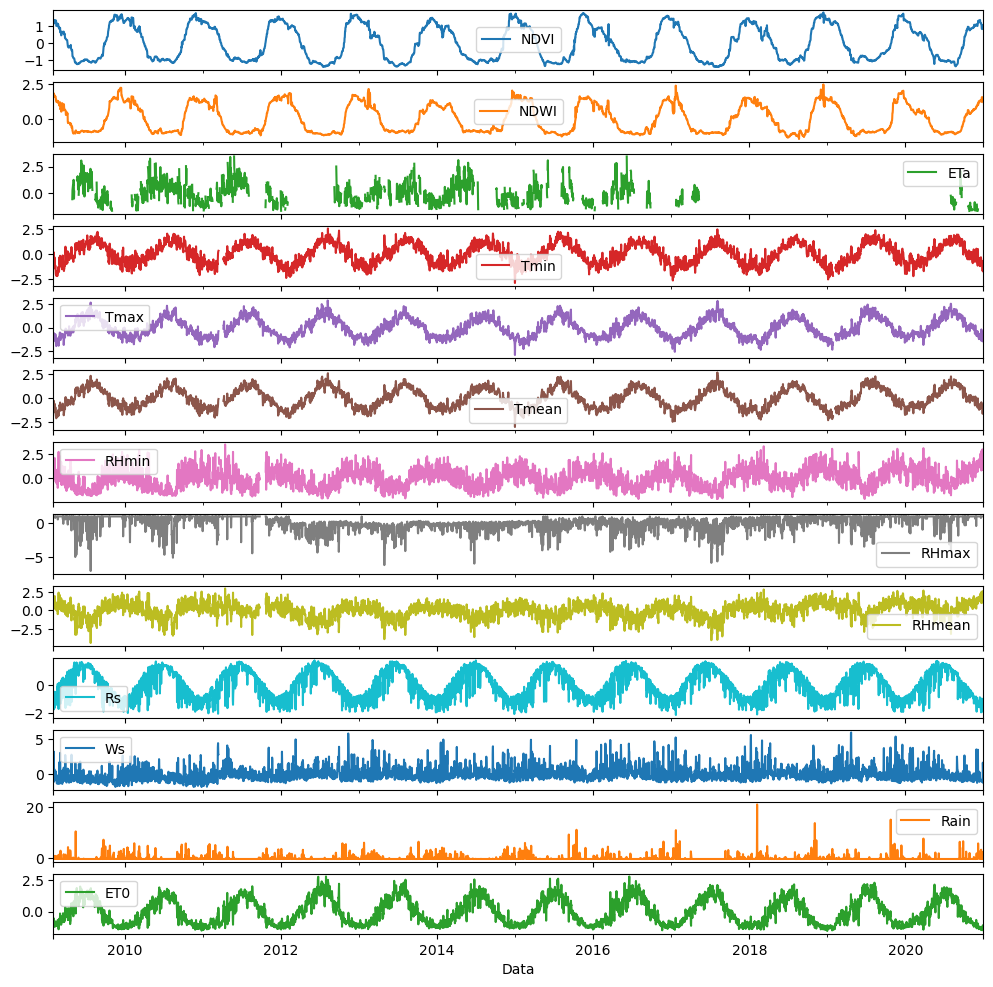

In [15]:
df = pd.read_pickle(PROJ_ROOT + '/data/interim/' + 'scaled.pickle')
df.plot(subplots=True, figsize=(12, 12))

<AxesSubplot:ylabel='Data'>

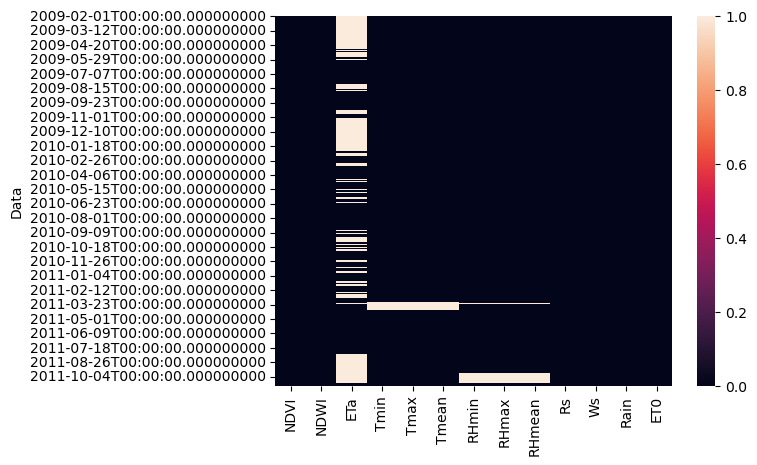

In [23]:
process = df.iloc[0:1000].resample('1D').mean()
sns.heatmap(process.isna())

546


<AxesSubplot:xlabel='Data'>

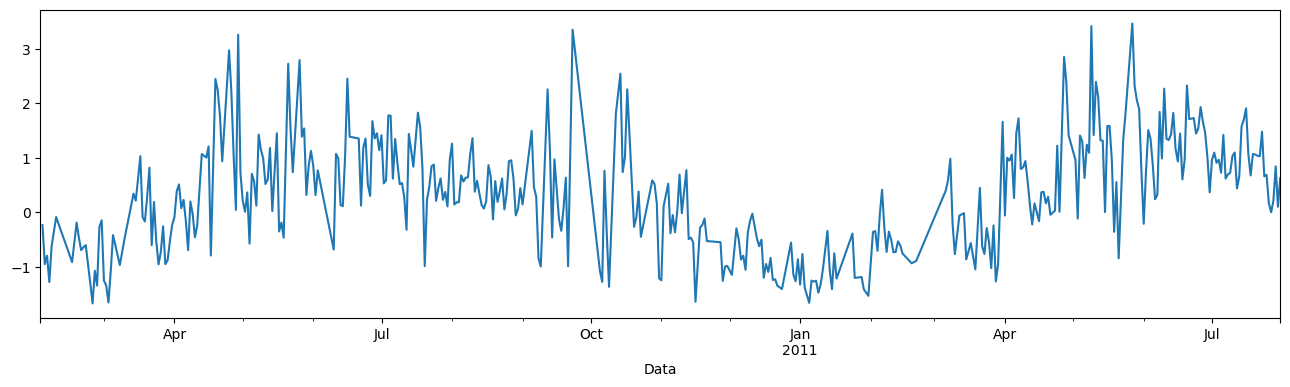

In [35]:
series = df.loc['2010-02':'2011-07'].resample('1D').interpolate()
print(len(series))
series['ETa'].plot(figsize=(16, 4))

In [57]:
X_train = series.iloc[:500, :-1].values
y_train = series.iloc[:500, -1].values.reshape(-1, 1)

X_test = series.iloc[500:, :-1].values
y_test = series.iloc[500:, -1].values.reshape(-1, 1)

print(f"X train shape: {X_train.shape}"
      f"y train shape: {y_train.shape}"
      f"X test shape: {X_test.shape}"
      f"y test shape: {y_test.shape}")

X train shape: (500, 12)y train shape: (500, 1)X test shape: (46, 12)y test shape: (46, 1)


In [58]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 


Training Shape torch.Size([500, 1, 12]) torch.Size([500, 1])
Testing Shape torch.Size([46, 1, 12]) torch.Size([46, 1])


In [59]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [60]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 12 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [61]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: nan
Epoch: 100, loss: nan
Epoch: 200, loss: nan
Epoch: 300, loss: nan
Epoch: 400, loss: nan
Epoch: 500, loss: nan
Epoch: 600, loss: nan
Epoch: 700, loss: nan
Epoch: 800, loss: nan
Epoch: 900, loss: nan
